# Monkey Pox Detection


In [ ]:
# Common 
import os
import keras
import numpy as np 
import tensorflow as tf

# Data
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization 
import plotly.express as px
import cv2
import matplotlib.pyplot as plt

# Models
from keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16


In [ ]:
info_file = '/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Monkeypox_Dataset_metadata.csv'
info = pd.read_csv(info_file)
info.head()

,ImageID,Label
0,M01_01,Monkeypox
1,M01_02,Monkeypox
2,M01_03,Monkeypox
3,M01_04,Monkeypox
4,M02_01,Monkeypox


In [ ]:
fig = px.pie(
    names=info.Label.unique(),
    values=info.Label.value_counts(),
    hole=0.2,
    width=500,
    height=500
)
fig.update_layout({'title':{'text':'Class Distribution','x':0.45}})
fig.show()

### Resnet Model on Original Images

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255,validation_split=0.4)

In [ ]:
train_data = train_gen.flow_from_directory("/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Train",target_size=(256,256),shuffle=True,class_mode='binary')
valid_data = valid_gen.flow_from_directory('/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Val',target_size=(256,256),shuffle=True,subset='training',class_mode='binary')
test_data = valid_gen.flow_from_directory('/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Original Images/Original Images',target_size=(256,256),shuffle=True,subset='validation',class_mode='binary')

Found 2142 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [ ]:
train_data.class_indices

{'Monkeypox': 0, 'Others': 1}

In [ ]:
base_model = ResNet50V2(
      include_top=False,
      input_shape=(256,256,3)
  )
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dense(164,activation='relu'),
    BatchNormalization(),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dense(2,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

cb = [EarlyStopping(patience=5,monitor='val_accuracy',mode='max',restore_best_weights=True),ModelCheckpoint("ResNet50V2-04.h5",save_best_only=True)]

history1 = model.fit(
    train_data,
    epochs=50,
    validation_data=valid_data,
    callbacks=cb
)

Epoch 1/50
67/67 [==============================] - 19s 218ms/step - loss: 0.3167 - accuracy: 0.8655 - val_loss: 0.6360 - val_accuracy: 0.6482
Epoch 2/50
67/67 [==============================] - 11s 163ms/step - loss: 0.0916 - accuracy: 0.9664 - val_loss: 0.4958 - val_accuracy: 0.7589
Epoch 3/50
67/67 [==============================] - 9s 137ms/step - loss: 0.0727 - accuracy: 0.9725 - val_loss: 0.7867 - val_accuracy: 0.6759
Epoch 4/50
67/67 [==============================] - 10s 149ms/step - loss: 0.0570 - accuracy: 0.9795 - val_loss: 0.7971 - val_accuracy: 0.7233
Epoch 5/50
67/67 [==============================] - 9s 139ms/step - loss: 0.0355 - accuracy: 0.9888 - val_loss: 0.9985 - val_accuracy: 0.7273
Epoch 6/50
67/67 [==============================] - 9s 140ms/step - loss: 0.0279 - accuracy: 0.9916 - val_loss: 1.0816 - val_accuracy: 0.6877
Epoch 7/50
67/67 [==============================] - 10s 142ms/step - loss: 0.0273 - accuracy: 0.9888 - val_loss: 0.7238 - val_accuracy: 0.7431


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 164)               42148     
                                                                 
 batch_normalization_7 (Batc  (None, 164)             

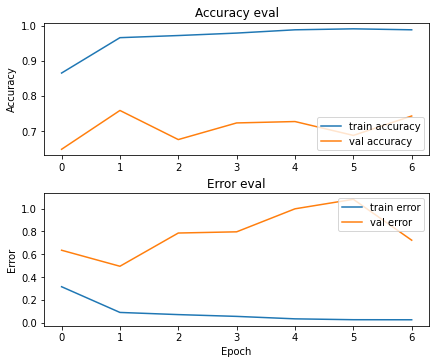

In [ ]:
plot_history(history1)

<h3>Testing Resnet Model on Original Images</h3>

In [ ]:
test_orig_data = valid_gen.flow_from_directory('/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Original Images/Original Images',target_size=(256,256),shuffle=True,subset='validation',class_mode='binary')

Found 90 images belonging to 2 classes.


In [ ]:
resnet_test_loss , resnet_test_acc = model.evaluate(test_orig_data)

3/3 [==============================] - 0s 116ms/step - loss: 0.0835 - accuracy: 0.9444


In [ ]:
resnet_train_loss, resnet_train_acc = model.evaluate(train_data)

67/67 [==============================] - 8s 124ms/step - loss: 0.0582 - accuracy: 0.9879


In [ ]:
print("Test Accuracy on Original Images: ")
print("Test_Accuracy : "+ str(orig_test_acc) + "  Test_loss : "+ str(orig_test_loss))

Test Accuracy on Original Images: 
Test_Accuracy : 0.931034505367279  Test_loss : 0.21523047983646393


<h4>Testing Model on Augumented Images</h4>

In [ ]:
test_aug_data = valid_gen.flow_from_directory('/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Augmented Images/Augmented Images',target_size=(256,256),shuffle=True,subset='validation',class_mode='binary')

Found 1276 images belonging to 2 classes.


In [ ]:
Augumented_img_test_loss , Augmented_img_test_acc = model.evaluate(test_aug_data)

40/40 [==============================] - 5s 124ms/step - loss: 0.2152 - accuracy: 0.9310


In [ ]:
print("Test Accuracy on Augumented Images: ")
print("Test_Accuracy : "+ str(Augmented_img_test_acc) + "  Test_loss : "+ str(Augumented_img_test_loss))

Test Accuracy on Augumented Images: 
Test_Accuracy : 0.931034505367279  Test_loss : 0.21523045003414154


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import load_model

resnet_model = load_model("/content/drive/MyDrive/Models/ResNet50V2final.h5")


1/1 [==============================] - 0s 22ms/step
[[0.9974126  0.00258745]]
Monkeypox


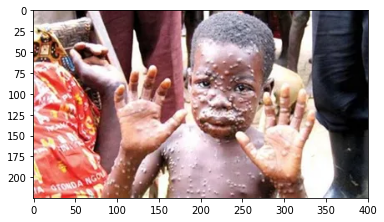

In [ ]:
x = plt.imread("mp3.webp")
plt.imshow(x)
x = cv2.resize(x,(256,256))
x = x.reshape(1,256,256,3)
x = x/255.0
op = model.predict(x)
print(op)
print(classes[np.argmax(op)])

Original Value  1.0
1/1 [==============================] - 0s 26ms/step
predicted value  1
Others


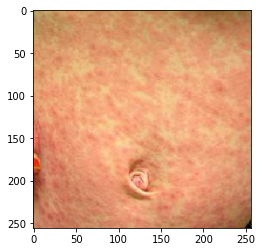

In [ ]:
print("Original Value ",test_data[0][1][6])
x = test_data[0][0][6]
plt.imshow(x)
x = cv2.resize(x,(256,256))
x = x.reshape(1,256,256,3)
x = x/255.0
op = model.predict(x)
print("predicted value ", np.argmax(op))
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 45ms/step
[[0.11098802 0.88901204]]
Others


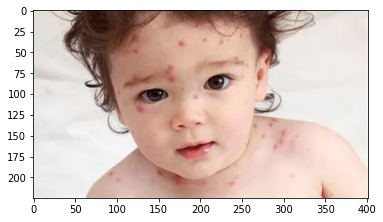

In [ ]:

x = plt.imread("cp2.webp")
plt.imshow(x)
x = cv2.resize(x,(256,256))
x = x.reshape(1,256,256,3)
x = x/255.0
op = model.predict(x)
print(op)
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 36ms/step
[[0.04658933 0.9534107 ]]
Others


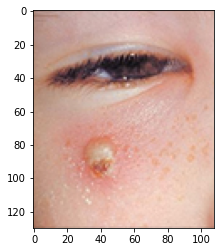

In [ ]:

x = plt.imread("cp.jpg")
plt.imshow(x)
x = cv2.resize(x,(256,256))
x = x.reshape(1,256,256,3)
x = x/255.0
op = model.predict(x)
print(op)
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 25ms/step
[[0.30636966 0.6936303 ]]
Others


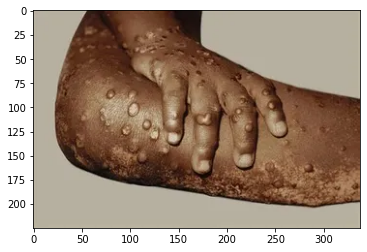

In [ ]:

x = plt.imread("mp.webp")
plt.imshow(x)
x = cv2.resize(x,(256,256))
x = x.reshape(1,256,256,3)
x = x/255.0
op = model.predict(x)
print(op)
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 23ms/step
[[0.11551602 0.884484  ]]
Others


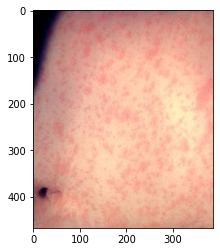

In [ ]:
x = plt.imread("m1.jpg")
plt.imshow(x)
x = cv2.resize(x,(256,256))
x = x.reshape(1,256,256,3)
x = x/255.0
op = model.predict(x)
print(op)
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 24ms/step
[[0.9723045  0.02769543]]
Monkeypox


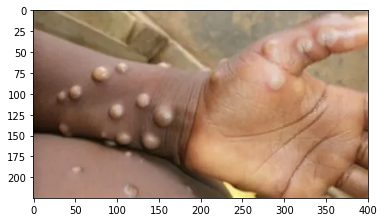

In [ ]:
x = plt.imread("m3.webp")
plt.imshow(x)
x = cv2.resize(x,(256,256))
x = x.reshape(1,256,256,3)
x = x/255.0
op = model.predict(x)
print(op)
print(classes[np.argmax(op)])

#Mobilenet

In [ ]:
train_data = train_gen.flow_from_directory("/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Train",target_size=(256,256),shuffle=True,class_mode='binary')
valid_data = valid_gen.flow_from_directory("/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Val",target_size=(256,256),shuffle=True,subset='training',class_mode='binary')
test_data = valid_gen.flow_from_directory('/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Val',target_size=(256,256),shuffle=True,subset='validation',class_mode='binary')

Found 2142 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Found 167 images belonging to 2 classes.


In [ ]:
import tensorflow
mobilenet = tensorflow.keras.applications.MobileNet(
    input_shape=None,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
)

In [ ]:
for layer in mobilenet.layers:
  layer.trainalbe = False

In [ ]:
mobilenet_model = keras.Sequential()
mobilenet_model.add(mobilenet)
mobilenet_model.add(keras.layers.Dense(units=256,activation="relu"))
mobilenet_model.add(keras.layers.Dense(units=256,activation="relu"))
mobilenet_model.add(keras.layers.Dense(units=128,activation="relu"))
mobilenet_model.add(keras.layers.Dense(units=2,activation="softmax"))

In [ ]:
mobilenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 256)               256256    
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4,609,066
Trainable params: 4,587,178
Non-trainable params: 21,888
_______________________________________

In [ ]:
mobilenet_model.compile(optimizer = Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = mobilenet_model.fit(train_data, epochs=50, validation_data= valid_data)

Epoch 1/50
67/67 [==============================] - 22s 278ms/step - loss: 0.6750 - accuracy: 0.5682 - val_loss: 0.6624 - val_accuracy: 0.6008
Epoch 2/50
67/67 [==============================] - 18s 265ms/step - loss: 0.4909 - accuracy: 0.8459 - val_loss: 0.5937 - val_accuracy: 0.6996
Epoch 3/50
67/67 [==============================] - 19s 275ms/step - loss: 0.2497 - accuracy: 0.9211 - val_loss: 0.8254 - val_accuracy: 0.6206
Epoch 4/50
67/67 [==============================] - 18s 272ms/step - loss: 0.1683 - accuracy: 0.9440 - val_loss: 0.9630 - val_accuracy: 0.6482
Epoch 5/50
67/67 [==============================] - 18s 267ms/step - loss: 0.1207 - accuracy: 0.9608 - val_loss: 0.9035 - val_accuracy: 0.7036
Epoch 6/50
67/67 [==============================] - 18s 268ms/step - loss: 0.1137 - accuracy: 0.9664 - val_loss: 1.3544 - val_accuracy: 0.6561
Epoch 7/50
67/67 [==============================] - 18s 273ms/step - loss: 0.1224 - accuracy: 0.9608 - val_loss: 1.1521 - val_accuracy: 0.6759

In [ ]:
def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="val accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="val error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    fig.set_figheight(5)
    fig.set_figwidth(6)
    fig.tight_layout(pad=0.5)
    plt.show()
    

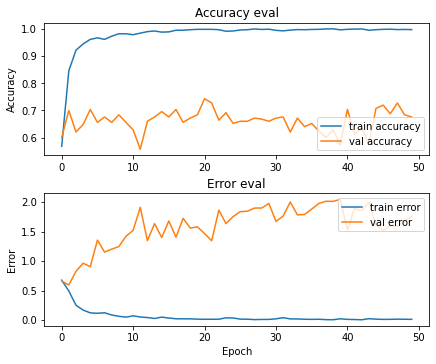

In [ ]:
plot_history(history2)

In [ ]:
mobilenet_test_loss, mobilenet_test_acc = mobilenet_model.evaluate(test_data)

6/6 [==============================] - 39s 8s/step - loss: 0.5040 - accuracy: 0.8383


In [ ]:
mobilenet_train_loss, mobilenet_train_acc = mobilenet_model.evaluate(train_data)

67/67 [==============================] - 7s 109ms/step - loss: 0.0354 - accuracy: 0.9921


In [ ]:
print("Mobilenet model Accuracy: ")
print("Train_Accuracy : "+ str(mobilenet_train_acc) + "  Train_loss : "+ str(mobilenet_train_loss))
print("Test_Accuracy : "+ str(mobilenet_test_acc) + "  Test_loss : "+ str(mobilenet_test_loss))

Mobilenet model Accuracy: 
Train_Accuracy : 0.9920634627342224  Train_loss : 0.035449396818876266
Test_Accuracy : 0.8383233547210693  Test_loss : 0.5040205717086792


In [ ]:
mobilenet_model.save("mobilenetmodelfinal.h5")

1/1 [==============================] - 1s 1s/step
[[0.00111048 0.9988895 ]]
Others


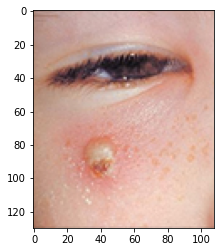

In [ ]:
x = plt.imread("cp.jpg")
plt.imshow(x)
x = cv2.resize(x,(224,224))
x = x.reshape(1,224,224,3)
x = x/255.0
op = mobilenet_model.predict(x)
print(op)
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 38ms/step
[[3.1992808e-04 9.9968004e-01]]
Others


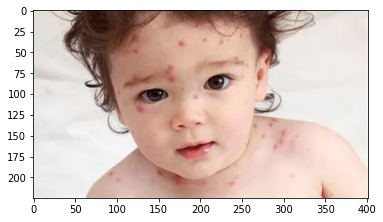

In [ ]:
x = plt.imread("cp2.webp")
plt.imshow(x)
x = cv2.resize(x,(224,224))
x = x.reshape(1,224,224,3)
x = x/255.0
op = mobilenet_model.predict(x)
print(op)
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 32ms/step
[[0.09064364 0.90935636]]
Others


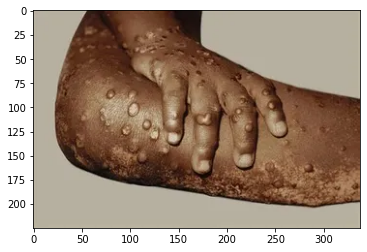

In [ ]:
x = plt.imread("mp.webp")
plt.imshow(x)
x = cv2.resize(x,(224,224))
x = x.reshape(1,224,224,3)
x = x/255.0
op = mobilenet_model.predict(x)
print(op)
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 21ms/step
[[9.993861e-01 6.138605e-04]]
Monkeypox


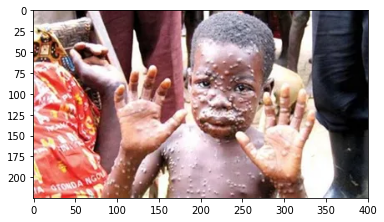

In [ ]:
x = plt.imread("mp3.webp")
plt.imshow(x)
x = cv2.resize(x,(224,224))
x = x.reshape(1,224,224,3)
x = x/255.0
op = mobilenet_model.predict(x)
print(op)
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 19ms/step
[[7.234214e-04 9.992766e-01]]
Others


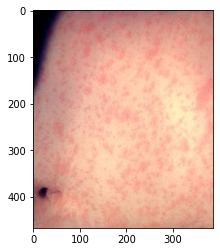

In [ ]:
x = plt.imread("m1.jpg")
plt.imshow(x)
x = cv2.resize(x,(224,224))
x = x.reshape(1,224,224,3)
x = x/255.0
op = mobilenet_model.predict(x)
print(op)
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 30ms/step
[[9.993874e-01 6.126259e-04]]
Monkeypox


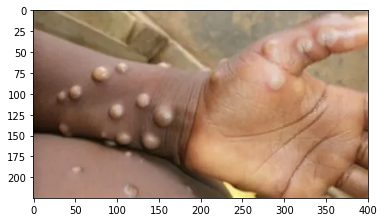

In [ ]:
x = plt.imread("m3.webp")
plt.imshow(x)
x = cv2.resize(x,(224,224))
x = x.reshape(1,224,224,3)
x = x/255.0
op = mobilenet_model.predict(x)
print(op)
print(classes[np.argmax(op)])

1/1 [==============================] - 0s 60ms/step
[[0.00634121 0.99365884]]
Others


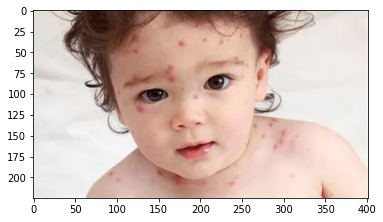

In [ ]:
x = plt.imread("cp2.webp")
plt.imshow(x)
x = cv2.resize(x,(224,224))
x = x.reshape(1,224,224,3)

op = mobilenet_model.predict(x)
print(op)
op = np.argmax(op)
print(classes[op])

In [ ]:
mobilenet_model.save("mobilenet_model.h5")

#CNN

In [ ]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# Keras - tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam


In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255,validation_split=0.4)

In [ ]:
train_data = train_gen.flow_from_directory("/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Train",target_size=(256,256),shuffle=True,class_mode='binary')
valid_data = valid_gen.flow_from_directory('/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Val',target_size=(256,256),shuffle=True,subset='training',class_mode='binary')
test_data = valid_gen.flow_from_directory('/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Val',target_size=(256,256),shuffle=True,subset='validation',class_mode='binary')

Found 2142 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Found 167 images belonging to 2 classes.


In [ ]:
cnn_model = keras.models.Sequential([
          #input layer takes 150x150x3 image 
          #Convolution and Maxpooling layers for feature extraction
          keras.layers.Conv2D(filters=32, kernel_size=3,activation='relu', input_shape=[256,256,3]),
          keras.layers.MaxPooling2D(pool_size=(2,2)),
          keras.layers.Conv2D(filters=64,activation='relu', kernel_size=3),
          keras.layers.MaxPooling2D(pool_size=(2,2)),
          keras.layers.Conv2D(filters=128,activation='relu', kernel_size=3),
          keras.layers.MaxPooling2D(pool_size=(2,2)),                                    
          keras.layers.Conv2D(filters=256,activation='relu', kernel_size=3),
          keras.layers.MaxPooling2D(pool_size=(2,2)),
          keras.layers.Dropout(0.5),

          #ANN layers for classification
          keras.layers.Flatten(), 
          keras.layers.Dense(units=128, activation='relu'), 
          keras.layers.Dropout(0.1),                                                                      
          keras.layers.Dense(units=2, activation='softmax') 
])

In [ ]:
cnn_model.compile(optimizer = Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 128)     

In [ ]:
CNN_Model = cnn_model.fit(train_data, epochs=25, validation_data = valid_data)

Epoch 1/25
67/67 [==============================] - 12s 150ms/step - loss: 0.6624 - accuracy: 0.6036 - val_loss: 0.5899 - val_accuracy: 0.7668
Epoch 2/25
67/67 [==============================] - 9s 127ms/step - loss: 0.6288 - accuracy: 0.6485 - val_loss: 0.6305 - val_accuracy: 0.5217
Epoch 3/25
67/67 [==============================] - 9s 129ms/step - loss: 0.5991 - accuracy: 0.6825 - val_loss: 0.6044 - val_accuracy: 0.5968
Epoch 4/25
67/67 [==============================] - 9s 141ms/step - loss: 0.5457 - accuracy: 0.7190 - val_loss: 0.5753 - val_accuracy: 0.6324
Epoch 5/25
67/67 [==============================] - 9s 127ms/step - loss: 0.4952 - accuracy: 0.7600 - val_loss: 0.5942 - val_accuracy: 0.6680
Epoch 6/25
67/67 [==============================] - 8s 126ms/step - loss: 0.4351 - accuracy: 0.7932 - val_loss: 0.5716 - val_accuracy: 0.7233
Epoch 7/25
67/67 [==============================] - 9s 129ms/step - loss: 0.4125 - accuracy: 0.8058 - val_loss: 0.5770 - val_accuracy: 0.6917
Epoch

In [ ]:
cnn_train_loss, cnn_train_acc = CNN_Model.model.evaluate(train_data)

67/67 [==============================] - 7s 104ms/step - loss: 0.0562 - accuracy: 0.9860


In [ ]:
cnn_test_loss, cnn_test_acc = CNN_Model.model.evaluate(test_data)

6/6 [==============================] - 1s 131ms/step - loss: 1.8795 - accuracy: 0.5389


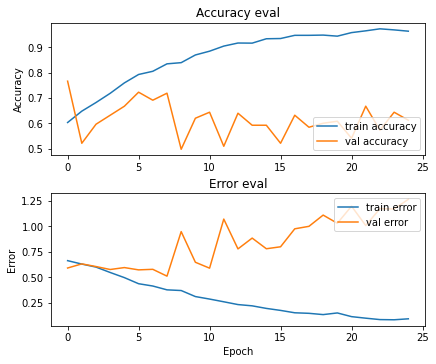

In [ ]:
plot_history(CNN_Model)

In [ ]:
CNN_Model.model.save("CnnModelfinal.h5")

In [ ]:
trainLoss = {"ResNet50V2 " : resnet_train_loss, "Mobilenet " : mobilenet_train_loss, "CNN " : cnn_train_loss }
testLoss = {"ResNet50V2 " : resnet_test_loss, "Mobilenet " : mobilenet_test_loss, "CNN " : cnn_test_loss }

In [ ]:
print(trainLoss)
print(testLoss)

{'ResNet50V2 ': 0.0581667460501194, 'Mobilenet ': 0.035449396818876266, 'CNN ': 0.05624306946992874}
{'ResNet50V2 ': 0.08349521458148956, 'Mobilenet ': 0.5040205717086792, 'CNN ': 1.8795151710510254}


In [ ]:
trainAccuracy = {"ResNet50V2 " : resnet_train_acc, "Mobilenet " : mobilenet_train_acc, "CNN " : cnn_train_acc}
testAccuracy = {"ResNet50V2 " : resnet_test_acc, "Mobilenet " : mobilenet_test_acc, "CNN " : cnn_test_acc}

In [ ]:
print(trainAccuracy)
print(testAccuracy)

{'ResNet50V2 ': 0.9878618121147156, 'Mobilenet ': 0.9920634627342224, 'CNN ': 0.9859943985939026}
{'ResNet50V2 ': 0.9444444179534912, 'Mobilenet ': 0.8383233547210693, 'CNN ': 0.538922131061554}


#VGG16

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255,validation_split=0.4)

In [ ]:
train_data = train_gen.flow_from_directory("/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Train",target_size=(224,224),shuffle=True,class_mode='binary')
valid_data = valid_gen.flow_from_directory('/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Val',target_size=(224,224),shuffle=True,subset='training',class_mode='binary')
test_data = valid_gen.flow_from_directory('/content/drive/MyDrive/Mini Project 4-1/Data/Monkeypox_Skin_dataset/Fold1/Fold1/Fold1/Val',target_size=(224,224),shuffle=True,subset='validation',class_mode='binary')

Found 2142 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Found 167 images belonging to 2 classes.


In [ ]:
vgg16 = VGG16(
    input_shape=None,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
)

553467096/553467096 [==============================] - 4s 0us/step


In [ ]:
for layer in vgg16.layers:
  layer.trainalbe = False

In [ ]:
vgg16_model = keras.Sequential()
vgg16_model.add(vgg16)

In [ ]:
vgg16_model.add(keras.layers.Dense(units=256,activation="relu"))
vgg16_model.add(keras.layers.Dense(units=128,activation="relu"))
vgg16_model.add(keras.layers.Dense(units=64,activation="relu"))
vgg16_model.add(keras.layers.Dense(units=2,activation="softmax"))

In [ ]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 138,655,082
Trainable params: 138,655,082
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vgg16_model.compile(optimizer = Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history4 = vgg16_model.fit(train_data, epochs=50, validation_data = valid_data)

Epoch 1/50
67/67 [==============================] - 347s 5s/step - loss: 0.6924 - accuracy: 0.5233 - val_loss: 0.6841 - val_accuracy: 0.6008
Epoch 2/50
67/67 [==============================] - 31s 461ms/step - loss: 0.6900 - accuracy: 0.5425 - val_loss: 0.6814 - val_accuracy: 0.6008
Epoch 3/50
67/67 [==============================] - 31s 468ms/step - loss: 0.6898 - accuracy: 0.5425 - val_loss: 0.6807 - val_accuracy: 0.6008
Epoch 4/50
67/67 [==============================] - 32s 472ms/step - loss: 0.6898 - accuracy: 0.5425 - val_loss: 0.6804 - val_accuracy: 0.6008
Epoch 5/50
67/67 [==============================] - 32s 474ms/step - loss: 0.6898 - accuracy: 0.5425 - val_loss: 0.6800 - val_accuracy: 0.6008
Epoch 6/50
67/67 [==============================] - 32s 478ms/step - loss: 0.6897 - accuracy: 0.5425 - val_loss: 0.6795 - val_accuracy: 0.6008
Epoch 7/50
67/67 [==============================] - 32s 481ms/step - loss: 0.6897 - accuracy: 0.5425 - val_loss: 0.6792 - val_accuracy: 0.6008
E

In [ ]:
vgg16_model.save("vgg.h5")

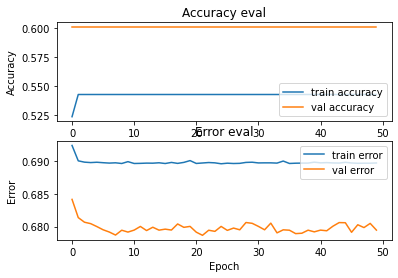

<Figure size 1.1808e+06x1.1088e+06 with 0 Axes>

In [ ]:
plot_history(history4)

In [ ]:
vgg16_model.evaluate(test_data)

6/6 [==============================] - 49s 10s/step - loss: 0.6797 - accuracy: 0.5988


[0.6796666979789734, 0.598802387714386]

In [ ]:
vgg16_model.evaluate(train_data)

67/67 [==============================] - 11s 157ms/step - loss: 0.6895 - accuracy: 0.5425


[0.6895360946655273, 0.5424836874008179]

In [ ]:
vgg16_model_2 = keras.Sequential()
vgg16_model_2.add(vgg16)

In [ ]:
vgg16_model_2.add(keras.layers.Dense(units=256,activation="relu"))
vgg16_model_2.add(keras.layers.Dense(units=256,activation="relu"))
vgg16_model_2.add(keras.layers.Dense(units=128,activation="relu"))
vgg16_model_2.add(keras.layers.Dense(units=128,activation="relu"))
vgg16_model_2.add(keras.layers.Dense(units=64,activation="relu"))
vgg16_model_2.add(keras.layers.Dense(units=2,activation="softmax"))

In [ ]:
vgg16_model_2.compile(optimizer = Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history5 = vgg16_model_2.fit(train_data, epochs = 30, validation_data = valid_data)

Epoch 1/30
67/67 [==============================] - 33s 494ms/step - loss: 0.6897 - accuracy: 0.5425 - val_loss: 0.6807 - val_accuracy: 0.6008
Epoch 2/30
67/67 [==============================] - 32s 476ms/step - loss: 0.6898 - accuracy: 0.5425 - val_loss: 0.6803 - val_accuracy: 0.6008
Epoch 3/30
67/67 [==============================] - 33s 486ms/step - loss: 0.6897 - accuracy: 0.5425 - val_loss: 0.6789 - val_accuracy: 0.6008
Epoch 4/30
67/67 [==============================] - 32s 479ms/step - loss: 0.6897 - accuracy: 0.5425 - val_loss: 0.6803 - val_accuracy: 0.6008
Epoch 5/30
67/67 [==============================] - 32s 483ms/step - loss: 0.6898 - accuracy: 0.5425 - val_loss: 0.6808 - val_accuracy: 0.6008
Epoch 6/30
67/67 [==============================] - 32s 482ms/step - loss: 0.6896 - accuracy: 0.5425 - val_loss: 0.6799 - val_accuracy: 0.6008
Epoch 7/30
67/67 [==============================] - 32s 478ms/step - loss: 0.6898 - accuracy: 0.5425 - val_loss: 0.6794 - val_accuracy: 0.6008

In [ ]:
train_Loss = {'ResNet50V2': 0.0581667460501194, 'Mobilenet': 0.035449396818876266, 'CNN': 0.05624306946992874, 'VGG16' : 0.6895  }
test_Loss = {'ResNet50V2': 0.08349521458148956, 'Mobilenet': 0.5040205717086792, 'CNN': 1.8795151710510254, 'VGG16' : 0.6797 }
train_Accuracy = {'ResNet50V2': 0.9878618121147156, 'Mobilenet': 0.9920634627342224, 'CNN': 0.9859943985939026, 'VGG16' : 0.5425 }
test_Accuracy = {'ResNet50V2': 0.9444444179534912, 'Mobilenet': 0.8383233547210693, 'CNN': 0.538922131061554, 'VGG16' : 0.5988}

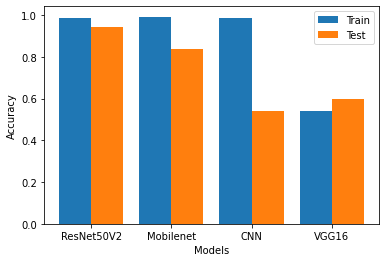

In [ ]:

import numpy as np 
import matplotlib.pyplot as plt 
  
X = list(train_Accuracy.keys())
Y = list(train_Accuracy.values())
Z = list(test_Accuracy.values())
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Test')
  
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

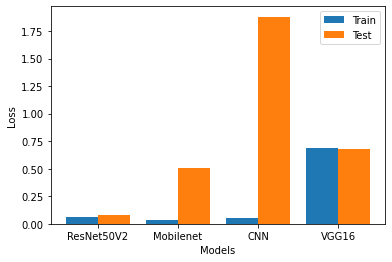

In [ ]:

import numpy as np 
import matplotlib.pyplot as plt 
  
X = list(train_Loss.keys())
Y = list(train_Loss.values())
Z = list(test_Loss.values())
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Test')
  
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import load_model

resnet_model = load_model("ResNet50V2final.h5")


In [ ]:
mobilenet_model = load_model("mobilenetmodelfinal.h5")
resnet_model = load_model("ResNet50V2final.h5")
cnn_model = load_model("CnnModelfinal.h5")
vgg_model = load_model("vgg16.h5")

OSError: ignored